In [22]:
# ===== 모델 초기화 (Apple Silicon Metal GPU) =====
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

print(f"TensorFlow 버전: {tf.__version__}")

# Metal GPU 확인 및 활성화
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ Metal GPU 발견: {len(gpus)}개")
    for gpu in gpus:
        print(f"   - {gpu.name}")
    # Metal에서는 memory_growth 설정하지 않음 (오히려 문제 발생)
    print("✅ Apple Silicon Metal GPU 활성화됨!")
else:
    print("⚠️ GPU가 발견되지 않았습니다. CPU를 사용합니다.")

# 간단한 GPU 테스트
print("\n=== GPU 연산 테스트 ===")
with tf.device('/GPU:0'):
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    c = tf.matmul(a, b)
print(f"GPU 연산 테스트 완료: shape = {c.shape}")

# Keras 백엔드 초기화
tf.keras.backend.clear_session()
print("\n✅ TensorFlow 및 Metal GPU 초기화 완료")

TensorFlow 버전: 2.16.2
✅ Metal GPU 발견: 1개
   - /physical_device:GPU:0
✅ Apple Silicon Metal GPU 활성화됨!

=== GPU 연산 테스트 ===
GPU 연산 테스트 완료: shape = (1000, 1000)

✅ TensorFlow 및 Metal GPU 초기화 완료

✅ TensorFlow 및 Metal GPU 초기화 완료


# 피싱 탐지를 위한 임베딩 모델

이 노트북은 피싱 탐지를 위한 임베딩 모델을 학습합니다.

## 목표
- Autoencoder를 사용하여 피싱 데이터의 저차원 임베딩 생성
- 학습된 임베딩 공간에서 코사인 유사도를 사용한 피싱 탐지
- 정상/피싱 샘플의 프로토타입 벡터 생성 및 저장

## 프레임워크
1. 데이터 로드 및 전처리
2. Autoencoder 모델 학습 (차원 축소)
3. 임베딩 공간에서 정상/피싱 프로토타입 생성
4. 유사도 기반 분류기 테스트
5. 모델 및 프로토타입 저장

In [23]:
# ===== 0) 환경 설정 및 Import =====
import os
os.environ['CONDA_DEFAULT_ENV'] = 'tf_env'

import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

print("TensorFlow 버전:", tf.__version__)
print("NumPy 버전:", np.__version__)
print("Pandas 버전:", pd.__version__)

TensorFlow 버전: 2.16.2
NumPy 버전: 1.26.4
Pandas 버전: 2.3.3


In [24]:
# ===== 1) 설정 =====
DATA_PATH = "/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/uci-ml-phishing-dataset.csv"
TARGET_COL = "Result"
EMBEDDING_DIM = 32  # 임베딩 차원 (원래 설정으로 복원)
BATCH_SIZE = 64  # 배치 크기 (원래 설정으로 복원)
EPOCHS = 200  # 에폭 (원래 설정으로 복원)
LEARNING_RATE = 0.001
RANDOM_SEED = 42

# 시드 설정
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"설정 완료: 임베딩 차원={EMBEDDING_DIM}, 배치 크기={BATCH_SIZE}, 에폭={EPOCHS}")

설정 완료: 임베딩 차원=32, 배치 크기=64, 에폭=200


In [25]:
# ===== 2) 데이터 로드 및 전처리 =====
df = pd.read_csv(DATA_PATH)
print(f"데이터 shape: {df.shape}")
print(f"\n컬럼 목록:\n{df.columns.tolist()}")
print(f"\n처음 5행:\n{df.head()}")

# 타겟 변수 확인
print(f"\n타겟 변수 ({TARGET_COL}) 분포:")
print(df[TARGET_COL].value_counts())

데이터 shape: (11055, 23)

컬럼 목록:
['id', 'having_IP_Address', 'URL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'Result']

처음 5행:
   id  having_IP_Address  URL_Length  Shortining_Service  having_At_Symbol  \
0   1                 -1           1                   1                 1   
1   2                  1           1                   1                 1   
2   3                  1           0                   1                 1   
3   4                  1           0                   1                 1   
4   5                  1           0                  -1                 1   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                        -1             -1           

In [26]:
# ===== 3) 피처 및 레이블 분리 =====
# 'id' 컬럼이 있다면 제거
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# 타겟 변수를 이진 레이블로 변환 (-1: 피싱, 1: 정상 -> 0: 피싱, 1: 정상)
y = df[TARGET_COL].values
y_binary = (y == 1).astype(np.float32)  # 1: 정상(legitimate), 0: 피싱(phishing)

# 피처 추출 (타겟 제외)
X = df.drop(columns=[TARGET_COL]).values.astype(np.float32)

print(f"피처 shape: {X.shape}")
print(f"레이블 shape: {y_binary.shape}")
print(f"레이블 분포: 정상={np.sum(y_binary==1)}, 피싱={np.sum(y_binary==0)}")

# Train/Val/Test 분리 (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_binary, test_size=0.4, stratify=y_binary, random_state=RANDOM_SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_SEED
)

print(f"\nTrain: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

피처 shape: (11055, 21)
레이블 shape: (11055,)
레이블 분포: 정상=6157, 피싱=4898

Train: (6633, 21), Val: (2211, 21), Test: (2211, 21)


In [27]:
# ===== 4) 데이터 확인 (스케일링 없이 원본 사용) =====
# UCI 피싱 데이터셋은 이미 -1, 0, 1로 정규화되어 있음
# 원본 스케일을 유지하여 범주형 의미 보존

# 원본 데이터를 그대로 사용 (스케일링 제거)
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

print("데이터 전처리 완료 (원본 스케일 유지)")
print(f"Train 피처 범위: min={X_train_scaled.min():.2f}, max={X_train_scaled.max():.2f}")
print(f"Train 피처 고유값: {np.unique(X_train_scaled)[:10]}")
print("\n⚠️ 참고: StandardScaler 제거됨 - 원본 -1, 0, 1 값 사용")

데이터 전처리 완료 (원본 스케일 유지)
Train 피처 범위: min=-1.00, max=1.00
Train 피처 고유값: [-1.  0.  1.]

⚠️ 참고: StandardScaler 제거됨 - 원본 -1, 0, 1 값 사용


In [28]:
# ===== 5) 분류 모델 구축 (Encoder + Classification Head) =====
keras.backend.clear_session()
gc.collect()

input_dim = X_train_scaled.shape[1]

# Encoder 부분
encoder_input = keras.Input(shape=(input_dim,), name='encoder_input')
x = layers.Dense(128, activation='relu', name='encoder_dense1')(encoder_input)
x = layers.BatchNormalization(name='encoder_bn1')(x)
x = layers.Dropout(0.3, name='encoder_dropout1')(x)
x = layers.Dense(64, activation='relu', name='encoder_dense2')(x)
x = layers.BatchNormalization(name='encoder_bn2')(x)
x = layers.Dropout(0.2, name='encoder_dropout2')(x)
x = layers.Dense(32, activation='relu', name='encoder_dense3')(x)
embedding = layers.Dense(EMBEDDING_DIM, activation='relu', name='embedding')(x)

# Classification Head (분류 헤드)
x = layers.Dense(16, activation='relu', name='classifier_dense1')(embedding)
x = layers.Dropout(0.2, name='classifier_dropout')(x)
output = layers.Dense(1, activation='sigmoid', name='output')(x)  # 0: 피싱, 1: 정상

# 전체 분류 모델
classifier = Model(inputs=encoder_input, outputs=output, name='phishing_classifier')

# Encoder만 따로 (임베딩 추출용)
encoder = Model(inputs=encoder_input, outputs=embedding, name='encoder')

classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

print("\n===== 분류 모델 구조 =====")
classifier.summary()
print("\n===== Encoder 모델 구조 =====")
encoder.summary()


===== 분류 모델 구조 =====


Model: "phishing_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense1 (Dense)          │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn1                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout1 (Dropout)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn2                     │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout2 (Dropout)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense3 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense1 (Dense)       │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dropout (Dropout)    │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,521 (60.63 KB)

 Trainable params: 15,137 (59.13 KB)

 Non-trainable params: 384 (1.50 KB)


===== Encoder 모델 구조 =====


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense1 (Dense)          │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn1                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout1 (Dropout)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn2                     │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout2 (Dropout)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense3 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 32)             │         1,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,976 (58.50 KB)

 Trainable params: 14,592 (57.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [29]:
# ===== 6) 분류 모델 학습 =====
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    )
]

history = classifier.fit(
    X_train_scaled, y_train,  # 피처 -> 레이블 (분류 학습)
    validation_data=(X_val_scaled, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\n분류 모델 학습 완료!")

Epoch 1/200
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8477 - auc: 0.9183 - loss: 0.3768 - val_accuracy: 0.9172 - val_auc: 0.9683 - val_loss: 0.2423 - learning_rate: 0.0010
Epoch 2/200
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8477 - auc: 0.9183 - loss: 0.3768 - val_accuracy: 0.9172 - val_auc: 0.9683 - val_loss: 0.2423 - learning_rate: 0.0010
Epoch 2/200
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8794 - auc: 0.9442 - loss: 0.3074 - val_accuracy: 0.9109 - val_auc: 0.9681 - val_loss: 0.2245 - learning_rate: 0.0010
Epoch 3/200
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8794 - auc: 0.9442 - loss: 0.3074 - val_accuracy: 0.9109 - val_auc: 0.9681 - val_loss: 0.2245 - learning_rate: 0.0010
Epoch 3/200
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8789 - auc: 0.9413 - loss: 0.3340 - val_accuracy: 0.9086 - val_auc: 0.9651 - val_loss: 0.2629 - learning_rate: 0.0010
Epoch 4/200
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.87

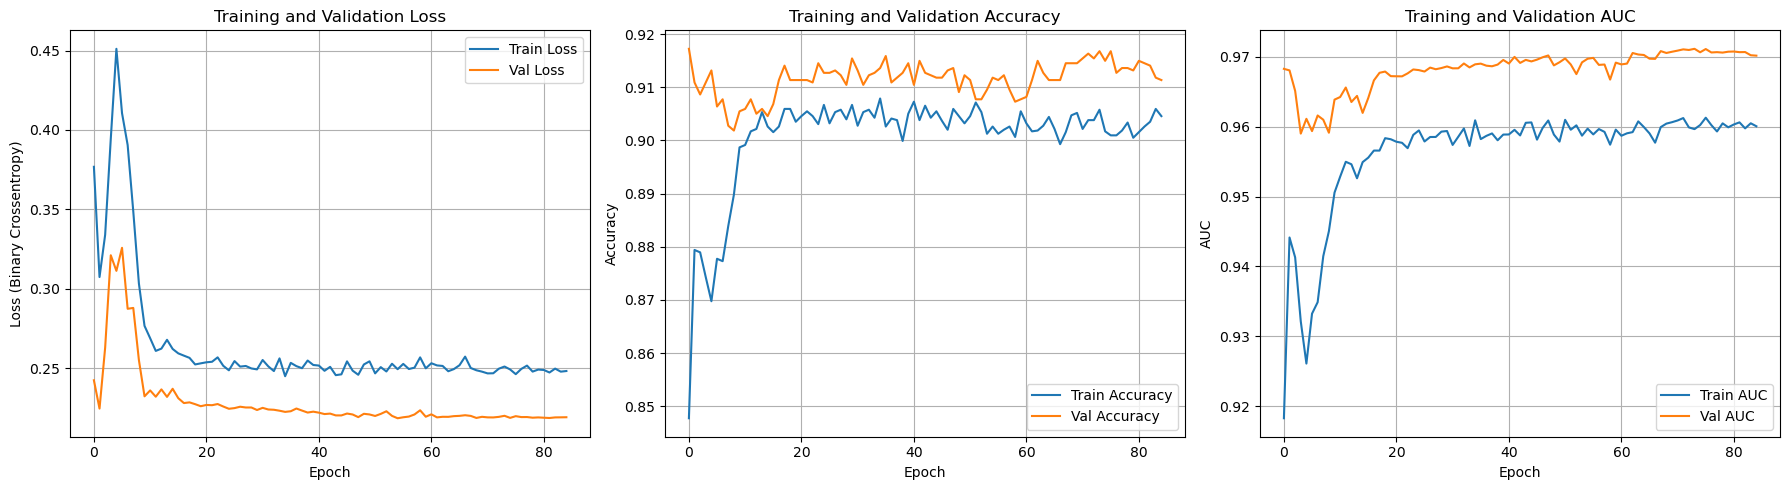

In [30]:
# ===== 7) 학습 곡선 시각화 =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (Binary Crossentropy)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

# AUC
axes[2].plot(history.history['auc'], label='Train AUC')
axes[2].plot(history.history['val_auc'], label='Val AUC')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].set_title('Training and Validation AUC')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [31]:
# ===== 8) 모델 평가 (Validation) =====
val_loss, val_acc, val_auc = classifier.evaluate(X_val_scaled, y_val, verbose=0)

print("===== Validation 세트 평가 결과 =====")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_acc:.4f}")
print(f"AUC: {val_auc:.4f}")

# 예측
pred_val = classifier.predict(X_val_scaled, verbose=0)
pred_val_binary = (pred_val > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_val, pred_val_binary, target_names=['Phishing', 'Legitimate']))

===== Validation 세트 평가 결과 =====
Loss: 0.2184
Accuracy: 0.9118
AUC: 0.9697

Classification Report:
              precision    recall  f1-score   support

    Phishing       0.92      0.87      0.90       979
  Legitimate       0.90      0.94      0.92      1232

    accuracy                           0.91      2211
   macro avg       0.91      0.91      0.91      2211
weighted avg       0.91      0.91      0.91      2211


Classification Report:
              precision    recall  f1-score   support

    Phishing       0.92      0.87      0.90       979
  Legitimate       0.90      0.94      0.92      1232

    accuracy                           0.91      2211
   macro avg       0.91      0.91      0.91      2211
weighted avg       0.91      0.91      0.91      2211



In [32]:
# ===== 9) 모델 평가 (Test) =====
test_loss, test_acc, test_auc = classifier.evaluate(X_test_scaled, y_test, verbose=0)

print("===== Test 세트 평가 결과 =====")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")
print(f"AUC: {test_auc:.4f}")

# 예측
pred_test = classifier.predict(X_test_scaled, verbose=0)
pred_test_binary = (pred_test > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_test, pred_test_binary, target_names=['Phishing', 'Legitimate']))

===== Test 세트 평가 결과 =====
Loss: 0.2049
Accuracy: 0.9199
AUC: 0.9736

Classification Report:
              precision    recall  f1-score   support

    Phishing       0.92      0.89      0.91       980
  Legitimate       0.92      0.94      0.93      1231

    accuracy                           0.92      2211
   macro avg       0.92      0.92      0.92      2211
weighted avg       0.92      0.92      0.92      2211



In [33]:
# ===== 10) ROC 커브 및 Confusion Matrix 시각화 =====
from sklearn.metrics import roc_curve, confusion_matrix
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {test_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Confusion Matrix
cm = confusion_matrix(y_test, pred_test_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Phishing', 'Legitimate'],
            yticklabels=['Phishing', 'Legitimate'])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'seaborn'

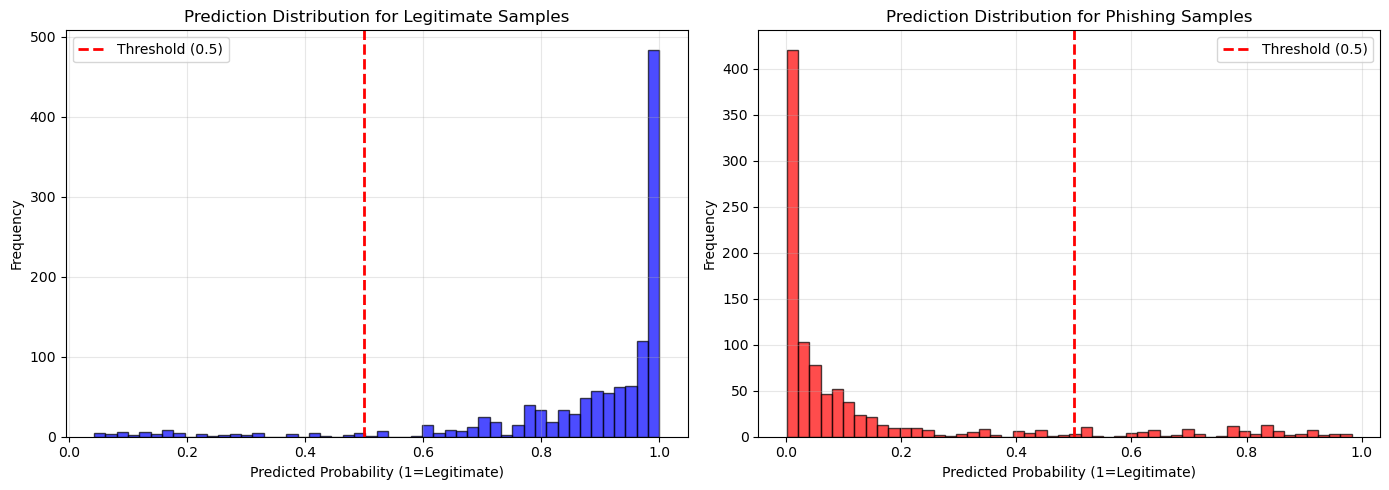


정상 사이트 평균 예측값: 0.8778
피싱 사이트 평균 예측값: 0.1364


In [34]:
# ===== 11) 예측 확률 분포 시각화 =====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

legit_mask = (y_test == 1)
phish_mask = (y_test == 0)

# 정상 사이트의 예측 확률 분포
axes[0].hist(pred_test[legit_mask], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[0].set_xlabel('Predicted Probability (1=Legitimate)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Prediction Distribution for Legitimate Samples')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 피싱 사이트의 예측 확률 분포
axes[1].hist(pred_test[phish_mask], bins=50, alpha=0.7, color='red', edgecolor='black')
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[1].set_xlabel('Predicted Probability (1=Legitimate)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Prediction Distribution for Phishing Samples')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n정상 사이트 평균 예측값: {pred_test[legit_mask].mean():.4f}")
print(f"피싱 사이트 평균 예측값: {pred_test[phish_mask].mean():.4f}")

t-SNE 변환 중...


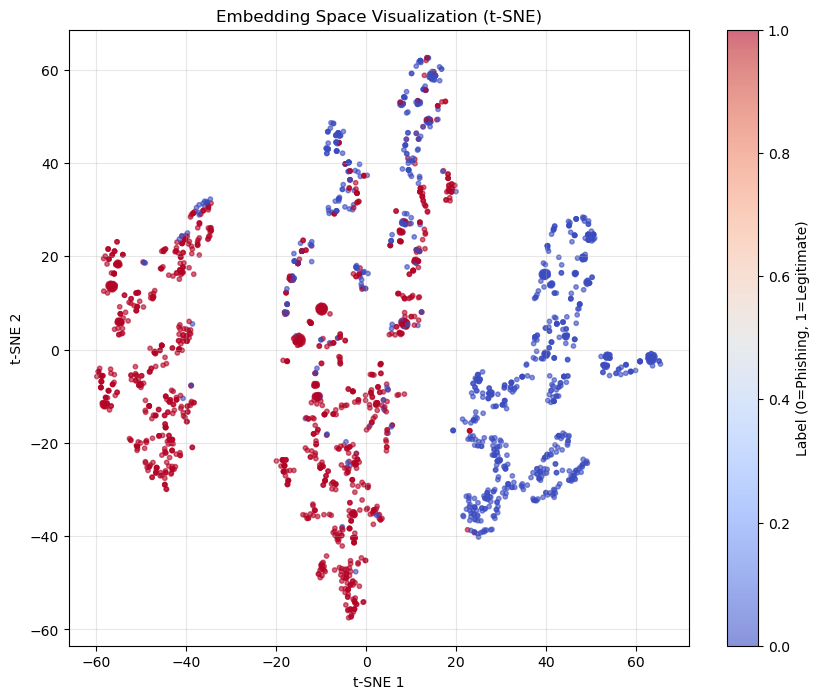

In [35]:
# ===== 12) 임베딩 공간 시각화 (t-SNE) =====
from sklearn.manifold import TSNE

# Encoder로 임베딩 추출
embeddings_test = encoder.predict(X_test_scaled, verbose=0)

# t-SNE 변환 (2D)
print("t-SNE 변환 중...")
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_test)

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=y_test, cmap='coolwarm', alpha=0.6, s=10)
plt.colorbar(scatter, label='Label (0=Phishing, 1=Legitimate)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Embedding Space Visualization (t-SNE)')
plt.grid(True, alpha=0.3)
plt.show()

In [36]:
# ===== 13) 모델 저장 및 TFLite 변환 =====
import os

# 모델 경로 설정
OUTPUT_DIR = "/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing"
CLASSIFIER_PATH = os.path.join(OUTPUT_DIR, "classifier_model.h5")
SAVED_MODEL_PATH = os.path.join(OUTPUT_DIR, "classifier_saved_model")
TFLITE_PATH = os.path.join(OUTPUT_DIR, "phishing_classifier.tflite")

# 1) Classifier 모델 H5로 저장
print(f"Classifier 모델 저장 중: {CLASSIFIER_PATH}")
classifier.save(CLASSIFIER_PATH)
print("H5 모델 저장 완료!")

# 2) SavedModel 형식으로 저장
print(f"SavedModel로 저장 중: {SAVED_MODEL_PATH}")
classifier.export(SAVED_MODEL_PATH)
print("SavedModel 저장 완료!")

# 3) SavedModel에서 TFLite로 변환
print("TFLite 변환 중...")
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_PATH)
tflite_model = converter.convert()

with open(TFLITE_PATH, 'wb') as f:
    f.write(tflite_model)

print(f"✅ TFLite 모델 저장 완료: {TFLITE_PATH}")
print(f"📦 모델 크기: {len(tflite_model) / 1024:.2f} KB")

# 4) TFLite 모델 검증
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(f"\n입력 shape: {input_details[0]['shape']}")
print(f"출력 shape: {output_details[0]['shape']}")
print("✅ TFLite 모델 검증 완료!")

Classifier 모델 저장 중: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/classifier_model.h5
H5 모델 저장 완료!
SavedModel로 저장 중: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/classifier_saved_model
INFO:tensorflow:Assets written to: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/classifier_saved_model/assets
INFO:tensorflow:Assets written to: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/classifier_saved_model/assets


INFO:tensorflow:Assets written to: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/classifier_saved_model/assets


Saved artifact at '/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/classifier_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 21), dtype=tf.float32, name='encoder_input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  14537261296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14537261472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14537262704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14537265168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14537263760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14537264112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14537263936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15429160272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15429160624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15429161152: TensorSpec(shape=(), dtype=tf.resource, name=

W0000 00:00:1764054356.369909 2901197 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1764054356.369923 2901197 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


In [37]:
# ===== 14) TFLite 모델 테스트 =====
import numpy as np

# 테스트 샘플로 검증
test_sample = X_test_scaled[0:5].astype(np.float32)

# TFLite 추론
interpreter.set_tensor(input_details[0]['index'], test_sample)
interpreter.invoke()
tflite_output = interpreter.get_tensor(output_details[0]['index'])

# Keras 모델 추론
keras_output = classifier.predict(test_sample, verbose=0)

print("===== TFLite vs Keras 출력 비교 =====")
for i in range(5):
    actual = "정상" if y_test[i] == 1 else "피싱"
    print(f"샘플 {i+1}: TFLite={tflite_output[i][0]:.4f}, Keras={keras_output[i][0]:.4f}, 실제={actual}")
    
print(f"\n최대 오차: {np.max(np.abs(tflite_output - keras_output)):.6f}")

ValueError: Cannot set tensor: Dimension mismatch. Got 5 but expected 1 for dimension 0 of input 0.

In [ ]:
# ===== 15) Android assets 폴더로 복사 =====
import shutil

ANDROID_ASSETS = "/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/app/src/main/assets"

# TFLite 모델 복사
shutil.copy(TFLITE_PATH, os.path.join(ANDROID_ASSETS, "phishing_classifier.tflite"))

print("✅ Android assets 폴더로 복사 완료!")
print(f"   {os.path.join(ANDROID_ASSETS, 'phishing_classifier.tflite')}")

# 최종 요약
print("\n" + "="*60)
print("✅ 피싱 분류 모델 생성 완료")
print("="*60)
print(f"\n📊 성능:")
print(f"   - Test Accuracy: {test_acc:.4f}")
print(f"   - Test AUC: {test_auc:.4f}")
print(f"\n📁 저장된 파일:")
print(f"   - phishing_classifier.tflite ({len(tflite_model) / 1024:.1f} KB)")
print(f"\n📱 Android 사용법:")
print("   - 입력: 21개 피처 (float32, -1/0/1 값)")
print("   - 출력: 1개 값 (0.0~1.0)")
print("   - 해석: 0.0 = 피싱, 1.0 = 정상")
print("   - 피싱 확률 = (1 - output) * 100%")
print("="*60)